<a href="https://colab.research.google.com/github/taktsutsumi/casaVisAnalysis/blob/master/MSaccessDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASA6のインストール
CASA6(Python3ベースのCASA)ではCASAのコンポーネントがモジュール化されており、必要なモジュールのみインストールして使うことが可能になった。
以下のステップでは、
CASA6に必要となるパケージ(gfortran3)とCASA6のcasa tasks及びcasa toolkitを使うためにcasatasksとcasatools をインストールしている。他に環境設定ファイル、toolrc.pyを作成する。

### ローカルマシン(今の所 Redhat linuxのみ）インストールする場合

    python3 -m venv casa6_0
    source casa6_0/bin/activate
    pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools
    pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks



### 以下は、Colab上で動かす場合



In [1]:
import os

print("installing pre-requiste package...")
os.system("apt-get install libgfortran3")
print("installing casa6 (casatools and casatasks)...")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatools")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatasks")
#os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools")
#os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks")

print("building config files...")
os.system("mkdir ~/.casa")
!echo home, datapath = '/root/', ['/root/data'] > ~/.casa/toolrc.py
!more /root/.casa/toolrc.py
print('complete')


installing pre-requiste package...
installing casa6 (casatools and casatasks)...
building config files...
home, datapath = /root/, [/root/data]
complete


In [2]:
%cd /root
%ls -a

/root
./   .bashrc  .casa/    .gsutil/   .jupyter/  .local/     .npm/
../  .cache/  .config/  .ipython/  .keras/    .node-gyp/  .profile


# サンプルデータのダウンロード

In [3]:
print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

downloading MeasurementSet from CASAguide First Look at Imaging...
complete


# 必要なCASAツール、タスクをインポートする

In [15]:
from casatools import ms, table, coordsys, measures, componentlist, quanta, ctsys, version_string
from casatasks import ft, imhead, listobs, split

import os
import pylab as pl
import numpy as np
#from astropy.io import fits
#from astropy.wcs import WCS


# Instantiate all the required tools
ms = ms()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()


In [5]:
# デフォルトのデータディレウトリ
ctsys.getpath()

['/usr/local/lib/python3.6/dist-packages/casadata/__data__']

In [6]:
# CASA Version のチェック
version_string()

'6.2.0.5'

MSデータの内容確認(listobs)

データの場所の確認

In [7]:
%ls

casa-20200731-220123.log            sis14_twhya_calibrated_flagged.ms.tar
sis14_twhya_calibrated_flagged.ms/


Listobs実行

In [8]:
listobs(vis='sis14_twhya_calibrated_flagged.ms', listfile='twhya-listobs.txt')
%cat twhya-listobs.txt

           MeasurementSet Name:  /root/sis14_twhya_calibrated_flagged.ms      MS Version 2
   Observer: cqi     Project: uid://A002/X327408/X6f  
Observation: ALMA
Data records: 80563       Total elapsed time = 5647.68 seconds
   Observed from   19-Nov-2012/07:36:57.0   to   19-Nov-2012/09:11:04.7 (UTC)

   ObservationID = 0         ArrayID = 0
  Date        Timerange (UTC)          Scan  FldId FieldName             nRows     SpwIds   Average Interval(s)    ScanIntent
  19-Nov-2012/07:36:57.0 - 07:39:13.1     4      0 J0522-364                 4200  [0]  [6.05] [CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE]
              07:44:45.2 - 07:47:01.2     7      2 Ceres                     3800  [0]  [6.05] [CALIBRATE_AMPLI#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE]
              07:52:42.0 - 07:53:47.6    10      3 J1037-295                 1900  [0]  [6.05] [CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE]
              07:56:23.5 - 08:0

EX: MSデータから必要なデータコラムを抽出

In [9]:
ms.open(thems='sis14_twhya_calibrated_flagged.ms')
# field id = 5 (TW Hya)を選択
ms.selectinit()
ms.select({'field_id':5})

# getdataを用い、データを抽出
# 選択できるデータのリストはhttps://casa.nrao.edu/docs/CasaRef/ms-Tool.html#x298-299002r6# を参照
vdata=ms.getdata(['amplitude', 'uvdist', 'axis_info'])
# amp 2 pol 384chan, time
print("amplitude shape: %s" % str(vdata['amplitude'][0][0].shape))
#print("time shape: %s" % str(vdata['time'].shape))
#print("axis_info: ", vdata['axis_info'])

amplitude shape: (53161,)


uvdist shape:  (53161,)
amplitude shape:  (2, 384, 53161)


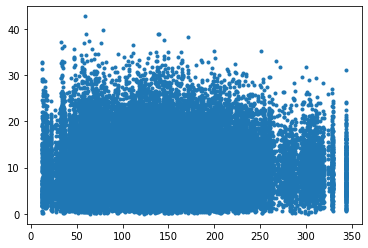

In [10]:
#pl.plot(vdata['time'],vdata['amplitude'][0][0])
print("uvdist shape: ", vdata['uvdist'].shape)
print("amplitude shape: ", vdata['amplitude'].shape)
pl.plot(vdata['uvdist'], vdata['amplitude'][0][0],'.')

In [11]:
# real, imaginary, time, uvw vector, weight
#vdata=ms.getdata(['real','imaginary', 'time', 'uvw','weight'])
vdata=ms.getdata(['real','imaginary', 'time', 'u','v','weight','sigma'])


#vdata=ms.getdata(['amplitude', 'time', 'uvw','weight','axis_info'])
#vdata=ms.getdata(["amplitude","axis_info"],ifraxis=True)

In [12]:
print(vdata['sigma'].shape)
print(vdata['sigma'][0][100])
print(vdata['weight'][0][100])

(2, 53161)
0.30571433901786804
10.699620246887207


In [13]:
# close ms tool
ms.close()

True

## Average over time + channels
扱いやすいように時間方向の平均をsplit(もしくはmstransform)タスクで行う。また、モデル用MSのコピーを作る。サンプルデータはspw１つのみなので、このspwのチャンネル方向の平均を行う。

In [73]:
%rm -r hwhya*.ms

In [76]:
split(vis='sis14_twhya_calibrated_flagged.ms',outputvis='twhya-tave.ms', datacolumn='data', field='TW Hya', timebin='1e8s', combine='scan', width=384)
split(vis='sis14_twhya_calibrated_flagged.ms',outputvis='twhya-model-tave.ms', datacolumn='data', field='TW Hya', timebin='1e8s',combine='scan', width=384)

True

In [77]:
%ls

casa-20200731-220123.log               twhya-listobs.txt
sis14_twhya_calibrated_flagged.ms/     twhya-model-tave.ms/
sis14_twhya_calibrated_flagged.ms.tar  twhya-tave.ms/


In [78]:
ms.open('twhya-tave.ms')
vdata=ms.getdata(['amplitude', 'time', 'uvdist'])
vdata2=ms.getdata(['real','imaginary'])
ms.close()

True

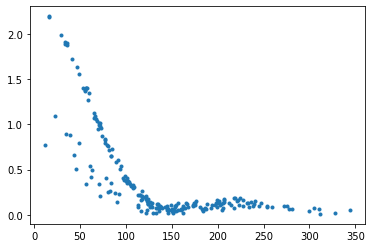

In [79]:
# plot amplitude (XX only) vs uv distance
fig=pl.plot(vdata['uvdist'], vdata['amplitude'][0][0],'.')

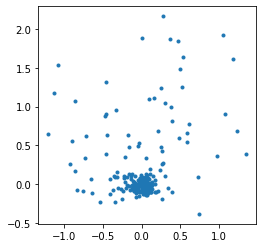

In [80]:
fig2=pl.figure()
ax=fig2.add_subplot(111)
ax.plot(vdata2['imaginary'][0][0], vdata2['real'][0][0],'.')
ax.set_aspect('equal')

モデルのビジビリティデータの作成

In [81]:
from casatools import simulator
sm = simulator()

In [83]:
sm.openfromms('twhya-model-tave.ms')
sm.setvp()

True

In [ ]:
# モデルイメージをUVでサンプリング
sm.predict(imagename='some-model-in-FITS')

In [85]:
sm.summary()
%cat casa*.log

2020-07-31 22:01:23	INFO	::casa	
2020-07-31 22:01:24	INFO	::casa	CASA Version 6.2.0.5
2020-07-31 22:01:24	INFO	::casa	Can't import casatelemetry module.
2020-07-31 22:05:04	INFO	listobs::::casa	##########################################
2020-07-31 22:05:04	INFO	listobs::::casa	##### Begin Task: listobs            #####
2020-07-31 22:05:04	INFO	listobs::::casa	listobs( vis='sis14_twhya_calibrated_flagged.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=True, listfile='twhya-listobs.txt', listunfl=False, cachesize=50.0, overwrite=False )
2020-07-31 22:05:04	INFO	listobs::ms::summary	Writing output to file: twhya-listobs.txt
2020-07-31 22:05:04	INFO	listobs::MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...
2020-07-31 22:05:04	INFO	listobs::::casa	Result listobs: True
2020-07-31 22:05:04	INFO	listobs::::casa	Task listobs complete. Start time: 202

* tclean niter=0 モデルのイメージ作成して確認
* ms.getdataで実データとモデルデータのMSからビジビリティデータを抽出
* scipyやastropyのフィッティングルーチンを使ってフィット？